In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np

# Introduction
In this notebook, we explore three models based on the literature - a gradient boosted tree (XGBoost) and two deep neural networks based on ResNet and Transformer acrhitectures. A tree based method is chosen as they have demonstrated good perfance on tabular data, while these two deep architectures mentioned have literature to suggest that they might surpass or at least perform competitively. 

## Loading the data

In [2]:
filename = 'cleanedAndEngineered_balanced_bothWays.csv'
df = pd.read_csv(filename, index_col = 0)
df = df.drop('customerID', axis = 1)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default,HighMonthlyCharges,ShortTenure
4684,0,0,1,0,72.0,1,2,0,2,2,...,2,2,2,1,0,86.40,6058.95,0,1,0
3571,0,0,0,1,53.0,1,2,0,0,2,...,2,2,1,1,2,84.60,4449.75,0,1,0
4210,0,0,1,1,24.0,1,2,0,2,0,...,2,2,2,0,1,78.60,1846.65,0,1,1
5563,0,0,1,1,72.0,1,2,1,2,2,...,2,2,2,1,1,116.40,8543.25,0,1,0
429,0,0,0,0,10.0,0,1,0,2,2,...,0,0,0,0,0,40.70,449.30,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6130,1,0,1,0,13.0,1,2,1,0,0,...,2,2,0,1,1,102.25,1359.00,1,1,1
2896,0,0,0,0,1.0,1,0,1,0,0,...,0,2,0,1,2,79.70,79.70,1,1,1
3549,1,0,1,0,31.0,1,2,1,0,2,...,2,0,0,0,2,93.80,3019.50,1,1,0
1055,1,1,0,0,12.0,0,1,0,0,0,...,0,2,0,1,2,43.65,526.95,1,0,1


In [151]:
df.shape

(7180, 22)

## Split

In [102]:
from sklearn.model_selection import train_test_split

test_size = 0.15

X = df.drop('Default', axis = 1)
Y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size)

# XGBoost

In [4]:
from xgboost import XGBClassifier

## Grid search

In [32]:
learning_rate = 0.05
n_estimators = 70
max_depth = 3
min_child_weight = 4
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
objective = 'binary:logistic'
scale_pos_weight = 1

model = XGBClassifier(use_label_encoder = False, 
                    learning_rate = learning_rate,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    gamma = gamma,
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    objective = objective,
                    scale_pos_weight = scale_pos_weight)

In [21]:
def gridSearch_kfold(k, param_grid, model):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits = n_splits, shuffle=True)
    grid_search = GridSearchCV(model, 
                               param_grid, 
                               scoring="neg_log_loss", 
                               n_jobs=1, 
                               cv=kfold)

    grid_result = grid_search.fit(X_train, y_train, eval_metric = 'logloss')

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [34]:
n_splits = 10
min_child_weight = range(1,6)
n_estimators = range(50, 150, 10)
max_depth = range(3,8)

param_grid = dict(min_child_weight = min_child_weight,
                 n_estimators = n_estimators,
                 max_depth = max_depth)

# grid search
gridSearch_kfold(k = n_splits, param_grid = param_grid, model = model)

    


Best: -0.397367 using {'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 140}
-0.488534 (0.016140) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
-0.481899 (0.016974) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 60}
-0.477063 (0.017912) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 70}
-0.473438 (0.018431) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 80}
-0.470704 (0.018997) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 90}
-0.468754 (0.019300) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
-0.467556 (0.019549) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 110}
-0.466172 (0.019681) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 120}
-0.464939 (0.019864) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 130}
-0.463901 (0.019933) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 140}
-0.488585 (0.016157) with: {'max_depth': 3

## Final model

In [5]:
learning_rate = 0.05
n_estimators = 140
max_depth = 7
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
objective = 'binary:logistic'
scale_pos_weight = 1

model = XGBClassifier(use_label_encoder = False, 
                    learning_rate = learning_rate,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    gamma = gamma,
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    objective = objective,
                    scale_pos_weight = scale_pos_weight)

[0]	validation_0-logloss:0.67205	validation_1-logloss:0.67520
[1]	validation_0-logloss:0.65228	validation_1-logloss:0.65901
[2]	validation_0-logloss:0.63472	validation_1-logloss:0.64432
[3]	validation_0-logloss:0.61823	validation_1-logloss:0.63040
[4]	validation_0-logloss:0.60298	validation_1-logloss:0.61777
[5]	validation_0-logloss:0.58866	validation_1-logloss:0.60655
[6]	validation_0-logloss:0.57584	validation_1-logloss:0.59560
[7]	validation_0-logloss:0.56354	validation_1-logloss:0.58552
[8]	validation_0-logloss:0.55208	validation_1-logloss:0.57657
[9]	validation_0-logloss:0.54132	validation_1-logloss:0.56845
[10]	validation_0-logloss:0.53163	validation_1-logloss:0.56049
[11]	validation_0-logloss:0.52200	validation_1-logloss:0.55284
[12]	validation_0-logloss:0.51329	validation_1-logloss:0.54635
[13]	validation_0-logloss:0.50488	validation_1-logloss:0.54016
[14]	validation_0-logloss:0.49753	validation_1-logloss:0.53376
[15]	validation_0-logloss:0.49044	validation_1-logloss:0.52889
[1

[130]	validation_0-logloss:0.28522	validation_1-logloss:0.40672
[131]	validation_0-logloss:0.28480	validation_1-logloss:0.40659
[132]	validation_0-logloss:0.28456	validation_1-logloss:0.40651
[133]	validation_0-logloss:0.28421	validation_1-logloss:0.40650
[134]	validation_0-logloss:0.28386	validation_1-logloss:0.40625
[135]	validation_0-logloss:0.28347	validation_1-logloss:0.40614
[136]	validation_0-logloss:0.28295	validation_1-logloss:0.40589
[137]	validation_0-logloss:0.28231	validation_1-logloss:0.40545
[138]	validation_0-logloss:0.28179	validation_1-logloss:0.40524
[139]	validation_0-logloss:0.28126	validation_1-logloss:0.40509
test accuracy 0.8263695450324977
test AUC 0.8227347879022662
test precision 0.8028616852146264
test recall 0.8890845070422535
test f1 0.8437761069340016
train accuracy 0.9023431099459283
train AUC 0.9005259953902132
train precision 0.875
train recall 0.9473186119873817
train f1_score 0.9097243259618296


<AxesSubplot:>

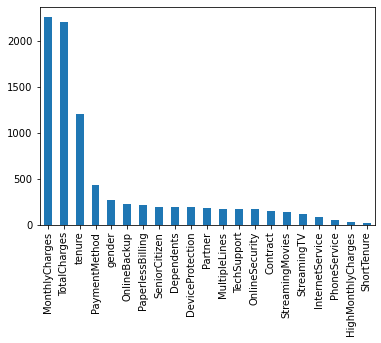

In [7]:
# fit
early_stopping_rounds = 15

model.fit(X_train, y_train,
          early_stopping_rounds = early_stopping_rounds,
          eval_set = [(X_train, y_train), (X_test, y_test)],
          eval_metric = ['logloss'], 
          verbose = True)

# predictions
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
print(f'test accuracy {accuracy_score(y_test, y_pred)}')
print(f'test AUC {roc_auc_score(y_test, y_pred)}')
print(f'test precision {precision_score(y_test, y_pred)}')
print(f'test recall {recall_score(y_test, y_pred)}')
print(f'test f1 {f1_score(y_test, y_pred)}')


print(f'train accuracy {accuracy_score(y_train, y_pred_train)}')
print(f'train AUC {roc_auc_score(y_train, y_pred_train)}')
print(f'train precision {precision_score(y_train, y_pred_train)}')
print(f'train recall {recall_score(y_train, y_pred_train)}')
print(f'train f1_score {f1_score(y_train, y_pred_train)}')


pd.Series(model.get_booster().get_fscore()).sort_values(ascending = False).plot(kind = 'bar')

In [8]:
model.save_model('XGB_v1.bin')

# ResNet

## Preparing the training set

In [120]:
def encodeCat_normalizeCts(df, cat_columns, cts_columns):
   
    # split data set into continuous and categorical, and encode/normalize
    df_model_cat = pd.DataFrame()
    df_model_cts = pd.DataFrame()

    # one hot encode categorical variables
    for col in cat_columns:
        if col != "customerID" and col != 'Default' and col in df.columns:
            temp = pd.get_dummies(df[col], prefix = col)
            df_model_cat = pd.concat([df_model_cat, temp], axis = 1)

    # append and standardize continuous variables
    have_cts = False
    cts_columns = df.select_dtypes(['float64']).columns
    for col in cts_columns:
        if col in df.columns:
            df_model_cts = pd.concat([df_model_cts, df[col]], axis = 1)
            have_cts = True

    X_cat = df_model_cat
    X_cts = df_model_cts
    Y = df["Default"].to_numpy().reshape(df.shape[0], 1)
    
    if have_cts:
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        s = StandardScaler()
        X_cts = np.log(X_cts)
        X_cts = s.fit_transform(X_cts)
    
    # concatenate standardized continuous and categorical
    return np.concatenate([X_cat, X_cts], axis = 1), Y

In [121]:
from sklearn.model_selection import train_test_split

test_size = 0.15

# encode, standardize, log transform
cat_columns = df.select_dtypes('int64').columns
cts_columns = df.select_dtypes('float64').columns
X, Y = encodeCat_normalizeCts(df, cat_columns, cts_columns)


In [122]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)

In [52]:
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)


In [53]:
metrics = [tf.metrics.BinaryAccuracy(threshold = 0.5), 
           tf.keras.metrics.AUC(name = 'AUC'),
           tf.keras.metrics.Precision(name ='precision'),
           tf.keras.metrics.Recall(name = 'recall'),
           F1_Score()         
          ]

## Defining models

In [42]:
# models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Layer
import keras.backend as K
import tensorflow_addons as tfa


In [43]:
class BinaryClassifier(Layer):
    def __init__(self, activation = tf.nn.sigmoid):
        super(BinaryClassifier, self).__init__()
        self.activate = activation
        self.dense = layers.Dense(units = 1) 
        
    def call(self, input_tensor):
        return self.activate(self.dense(((input_tensor))))
    
class ResNetBlock(Layer):
    def __init__(self, hiddenUnits = 16, resDropoutRate = 0.25, hiddenDropoutRate = 0.25, activation = tf.nn.relu):
        super(ResNetBlock, self).__init__()
        self.bn = layers.BatchNormalization()
        self.hiddenDrop = layers.Dropout(hiddenDropoutRate)
        self.dense1 = layers.Dense(units = hiddenUnits, activation = activation)
        self.dense2 = layers.Dense(units = hiddenUnits)
        self.resDrop = layers.Dropout(resDropoutRate)
    
    def call(self, input_tensor):
        return input_tensor + self.resDrop(self.dense2(self.hiddenDrop(self.dense1(self.bn(input_tensor)))))
        


In [44]:
class ResNet2(Model):
    def __init__(self, hiddenUnits, inp_shape):
        super(ResNet2, self).__init__()
        self.inp_shape = inp_shape
        self.dense = layers.Dense(units = hiddenUnits)
        self.res1 = ResNetBlock(hiddenUnits)
        self.res2 = ResNetBlock(hiddenUnits)

        self.final = BinaryClassifier()
        
    def call(self, input_tensor):
        x = self.dense(input_tensor)
        x = self.res2(self.res1(x))
        return self.final(x)
    
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))


class ResNet4(Model):
    def __init__(self, hiddenUnits, inp_shape):
        super(ResNet4, self).__init__()
        self.inp_shape = inp_shape
        self.dense = layers.Dense(units = hiddenUnits)
        self.res1 = ResNetBlock(hiddenUnits)
        self.res2 = ResNetBlock(hiddenUnits)
        self.res3 = ResNetBlock(hiddenUnits)
        self.res4 = ResNetBlock(hiddenUnits)
        self.final = BinaryClassifier()
        
    def call(self, input_tensor):
        x = self.dense(input_tensor)
        x = self.res4(self.res3(self.res2(self.res1(x))))
        return self.final(x)
    
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))

    
class ResNet8(Model):
    def __init__(self, hiddenUnits, inp_shape):
        super(ResNet8, self).__init__()
        self.inp_shape = inp_shape
        self.dense = layers.Dense(units = hiddenUnits)
        self.res1 = ResNetBlock(hiddenUnits)
        self.res2 = ResNetBlock(hiddenUnits)
        self.res3 = ResNetBlock(hiddenUnits)
        self.res4 = ResNetBlock(hiddenUnits)
        self.res5 = ResNetBlock(hiddenUnits)
        self.res6 = ResNetBlock(hiddenUnits)
        self.res7 = ResNetBlock(hiddenUnits)
        self.res8 = ResNetBlock(hiddenUnits)
        self.final = BinaryClassifier()
        
    def call(self, input_tensor):
        x = self.dense(input_tensor)
        x = self.res4(self.res3(self.res2(self.res1(x))))
        x = self.res8(self.res7(self.res6(self.res5(x))))
        return self.final(x)
    
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))




In [45]:
class ResNet4_ensemble5(Model):
    def __init__(self, hiddenUnits, inp_shape):
        super(ResNet4_ensemble5, self).__init__()
        self.inp_shape = inp_shape
        self.res1 = ResNet4(hiddenUnits, inp_shape)
        self.res2 = ResNet4(hiddenUnits, inp_shape)
        self.res3 = ResNet4(hiddenUnits, inp_shape)
        self.res4 = ResNet4(hiddenUnits, inp_shape)
        self.res5 = ResNet4(hiddenUnits, inp_shape)
        
        
    def call(self, input_tensor):
        x1 = self.res1(input_tensor)
        x2 = self.res2(input_tensor)
        x3 = self.res3(input_tensor)
        x4 = self.res4(input_tensor)
        x5 = self.res5(input_tensor)
        x = (x1 + x2 + x3 + x4 + x5)/5
        return x
    
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))

In [46]:
class ResNet2_ensemble5(Model):
    def __init__(self, hiddenUnits, inp_shape):
        super(ResNet2_ensemble5, self).__init__()
        self.inp_shape = inp_shape
        self.res1 = ResNet2(hiddenUnits, inp_shape)
        self.res2 = ResNet2(hiddenUnits, inp_shape)
        self.res3 = ResNet2(hiddenUnits, inp_shape)
        self.res4 = ResNet2(hiddenUnits, inp_shape)
        self.res5 = ResNet2(hiddenUnits, inp_shape)
        
        
    def call(self, input_tensor):
        x1 = self.res1(input_tensor)
        x2 = self.res2(input_tensor)
        x3 = self.res3(input_tensor)
        x4 = self.res4(input_tensor)
        x5 = self.res5(input_tensor)
        x = (x1 + x2 + x3 + x4 + x5)/5
        return x
    
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))

In [47]:
class ResNet8_ensemble5(Model):
    def __init__(self, hiddenUnits, inp_shape):
        super(ResNet8_ensemble5, self).__init__()
        self.inp_shape = inp_shape
        self.dense = layers.Dense(units = hiddenUnits)
        self.res1 = ResNet8(hiddenUnits, inp_shape)
        self.res2 = ResNet8(hiddenUnits, inp_shape)
        self.res3 = ResNet8(hiddenUnits, inp_shape)
        self.res4 = ResNet8(hiddenUnits, inp_shape)
        self.res5 = ResNet8(hiddenUnits, inp_shape)
        
        
    def call(self, input_tensor):
        x1 = self.res1(input_tensor)
        x2 = self.res2(input_tensor)
        x3 = self.res3(input_tensor)
        x4 = self.res4(input_tensor)
        x5 = self.res5(input_tensor)
        x = (x1 + x2 + x3 + x4 + x5)/5
        return x
    
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))

## Testing model

In [57]:
def kfold_train(X, Y, n_splits, learning_rate, batch_size, epochs, validation_split, callbacks, metrics):
    import matplotlib.pyplot as plt
    # initializing plots and results
    fig, ax = plt.subplots(nrows = len(metrics), figsize = (10, 30))
    results = np.empty((n_splits,len(metrics) + 1), dtype = 'float64')
    count = 0

    # train test kfold
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = n_splits, shuffle = True).split(X)
    for train_index, test_index in kf:
        print("\n##### NEW RUN {count + 1} ##### \n")
        
        # set train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ----- define model ----- 
        ##### CHANGE HERE #####
        model = ResNet2_ensemble5(2, (50,))
        model.model().summary()
        
        # ----- compile model -----
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics = metrics
             )

        # ----- train and validate model -----
        history = model.fit(X_train, y_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            callbacks = callbacks,
                            validation_split = validation_split,
                            shuffle = True)


        for m in range(len(metrics)):
            ax[m].set_xlabel("epoch")
            ax[m].set_title(f"Train and validation {metrics[m].name}")
            ax[m].plot(history.history[f'val_{metrics[m].name}'], label = f"validation{count}", color = 'r')
            ax[m].plot(history.history[f'{metrics[m].name}'], label = f"train{count}", color = 'b')
        
        # evaluation
        results[count] = model.evaluate(X_test, y_test)
        count += 1

    mean = np.mean(results, axis = 0)
    std = np.std(results, axis = 0)
    print("##### Results #####")
    for m in range(0,len(metrics)):
        print(f'{metrics[m].name} mean is: {mean[m+1]}, std. deviation is: {std[m+1]}')

    return results


##### NEW RUN ##### 

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
res_net2_30 (ResNet2)           (None, 1)            145         input_5[0][0]                    
__________________________________________________________________________________________________
res_net2_31 (ResNet2)           (None, 1)            145         input_5[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_16 (TFOpLa (None, 1)            0           res_net2_30[0][0]                
                                                                 res_

23/23 [==============================] - 1s 43ms/step - loss: 0.5048 - binary_accuracy: 0.7587 - AUC: 0.8352 - precision: 0.7449 - recall: 0.7370 - f1_score: 0.7409 - val_loss: 0.5134 - val_binary_accuracy: 0.7388 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7388 - val_f1_score: 0.8498
Epoch 18/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.5005 - binary_accuracy: 0.7618 - AUC: 0.8376 - precision: 0.7450 - recall: 0.7469 - f1_score: 0.7459 - val_loss: 0.5104 - val_binary_accuracy: 0.7388 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7388 - val_f1_score: 0.8498
Epoch 19/1000
23/23 [==============================] - 1s 46ms/step - loss: 0.4992 - binary_accuracy: 0.7656 - AUC: 0.8383 - precision: 0.7465 - recall: 0.7561 - f1_score: 0.7512 - val_loss: 0.5055 - val_binary_accuracy: 0.7388 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7388 - val_f1_score: 0.8498
Epoch 20/1000
23/23 [==============================] - 1s 45

23/23 [==============================] - 7s 89ms/step - loss: 0.7060 - binary_accuracy: 0.5602 - AUC: 0.5664 - precision: 0.5659 - recall: 0.2716 - f1_score: 0.3670 - val_loss: 0.9660 - val_binary_accuracy: 0.0062 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.0062 - val_f1_score: 0.0123
Epoch 2/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.6724 - binary_accuracy: 0.5797 - AUC: 0.6086 - precision: 0.5769 - recall: 0.3532 - f1_score: 0.4382 - val_loss: 0.8475 - val_binary_accuracy: 0.1036 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.1036 - val_f1_score: 0.1877
Epoch 3/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.6394 - binary_accuracy: 0.6330 - AUC: 0.6949 - precision: 0.6385 - recall: 0.4818 - f1_score: 0.5492 - val_loss: 0.7695 - val_binary_accuracy: 0.3462 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.3462 - val_f1_score: 0.5144
Epoch 4/1000
23/23 [==============================] - 1s 42ms/

Epoch 27/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.4906 - binary_accuracy: 0.7627 - AUC: 0.8413 - precision: 0.7444 - recall: 0.7439 - f1_score: 0.7442 - val_loss: 0.5154 - val_binary_accuracy: 0.7403 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7403 - val_f1_score: 0.8508
Epoch 28/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.4895 - binary_accuracy: 0.7623 - AUC: 0.8426 - precision: 0.7433 - recall: 0.7450 - f1_score: 0.7442 - val_loss: 0.5112 - val_binary_accuracy: 0.7434 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7434 - val_f1_score: 0.8528
Epoch 29/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.4909 - binary_accuracy: 0.7603 - AUC: 0.8412 - precision: 0.7424 - recall: 0.7402 - f1_score: 0.7413 - val_loss: 0.5228 - val_binary_accuracy: 0.7357 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7357 - val_f1_score: 0.8477
Epoch 30/1000
23/23 [=========================

23/23 [==============================] - 7s 97ms/step - loss: 0.6617 - binary_accuracy: 0.6245 - AUC: 0.6779 - precision: 0.5870 - recall: 0.7340 - f1_score: 0.6523 - val_loss: 0.6843 - val_binary_accuracy: 0.5734 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5734 - val_f1_score: 0.7289
Epoch 2/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.6317 - binary_accuracy: 0.6554 - AUC: 0.7216 - precision: 0.6150 - recall: 0.7199 - f1_score: 0.6633 - val_loss: 0.6473 - val_binary_accuracy: 0.6631 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6631 - val_f1_score: 0.7974
Epoch 3/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.6131 - binary_accuracy: 0.6985 - AUC: 0.7554 - precision: 0.6586 - recall: 0.7487 - f1_score: 0.7008 - val_loss: 0.6104 - val_binary_accuracy: 0.7218 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7218 - val_f1_score: 0.8384
Epoch 4/1000
23/23 [==============================] - 1s 44ms/

23/23 [==============================] - 7s 87ms/step - loss: 0.7089 - binary_accuracy: 0.5099 - AUC: 0.5346 - precision: 0.4773 - recall: 0.4835 - f1_score: 0.4804 - val_loss: 0.7807 - val_binary_accuracy: 0.2148 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.2148 - val_f1_score: 0.3537
Epoch 2/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.6875 - binary_accuracy: 0.5365 - AUC: 0.5557 - precision: 0.5032 - recall: 0.4945 - f1_score: 0.4988 - val_loss: 0.7227 - val_binary_accuracy: 0.4080 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.4080 - val_f1_score: 0.5796
Epoch 3/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.6684 - binary_accuracy: 0.6071 - AUC: 0.6361 - precision: 0.5795 - recall: 0.5741 - f1_score: 0.5768 - val_loss: 0.6786 - val_binary_accuracy: 0.5904 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5904 - val_f1_score: 0.7425
Epoch 4/1000
23/23 [==============================] - 1s 44ms/


Epoch 00026: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 27/1000
23/23 [==============================] - 1s 39ms/step - loss: 0.4967 - binary_accuracy: 0.7660 - AUC: 0.8388 - precision: 0.7525 - recall: 0.7423 - f1_score: 0.7474 - val_loss: 0.5005 - val_binary_accuracy: 0.7465 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7465 - val_f1_score: 0.8549
Epoch 28/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.4979 - binary_accuracy: 0.7675 - AUC: 0.8372 - precision: 0.7553 - recall: 0.7419 - f1_score: 0.7485 - val_loss: 0.4993 - val_binary_accuracy: 0.7481 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7481 - val_f1_score: 0.8559
Epoch 29/1000
23/23 [==============================] - 1s 45ms/step - loss: 0.4985 - binary_accuracy: 0.7625 - AUC: 0.8370 - precision: 0.7495 - recall: 0.7371 - f1_score: 0.7433 - val_loss: 0.4988 - val_binary_accuracy: 0.7481 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_re

23/23 [==============================] - 1s 44ms/step - loss: 0.4948 - binary_accuracy: 0.7699 - AUC: 0.8400 - precision: 0.7567 - recall: 0.7467 - f1_score: 0.7517 - val_loss: 0.4950 - val_binary_accuracy: 0.7481 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7481 - val_f1_score: 0.8559
Epoch 52/1000
23/23 [==============================] - 1s 45ms/step - loss: 0.4950 - binary_accuracy: 0.7660 - AUC: 0.8396 - precision: 0.7520 - recall: 0.7434 - f1_score: 0.7476 - val_loss: 0.4951 - val_binary_accuracy: 0.7481 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7481 - val_f1_score: 0.8559
Epoch 53/1000
23/23 [==============================] - 1s 45ms/step - loss: 0.4919 - binary_accuracy: 0.7668 - AUC: 0.8422 - precision: 0.7530 - recall: 0.7441 - f1_score: 0.7485 - val_loss: 0.4952 - val_binary_accuracy: 0.7481 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7481 - val_f1_score: 0.8559

Epoch 00053: ReduceLROnPlateau reducing learning rate to 5.

23/23 [==============================] - 1s 41ms/step - loss: 0.5399 - binary_accuracy: 0.7429 - AUC: 0.8145 - precision: 0.7217 - recall: 0.7273 - f1_score: 0.7245 - val_loss: 0.5693 - val_binary_accuracy: 0.7264 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7264 - val_f1_score: 0.8415
Epoch 13/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.5354 - binary_accuracy: 0.7463 - AUC: 0.8169 - precision: 0.7220 - recall: 0.7388 - f1_score: 0.7303 - val_loss: 0.5624 - val_binary_accuracy: 0.7264 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7264 - val_f1_score: 0.8415
Epoch 14/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.5257 - binary_accuracy: 0.7484 - AUC: 0.8233 - precision: 0.7246 - recall: 0.7399 - f1_score: 0.7322 - val_loss: 0.5561 - val_binary_accuracy: 0.7202 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7202 - val_f1_score: 0.8374
Epoch 15/1000
23/23 [==============================] - 1s 42


Epoch 00037: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 38/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.4875 - binary_accuracy: 0.7658 - AUC: 0.8442 - precision: 0.7436 - recall: 0.7573 - f1_score: 0.7504 - val_loss: 0.5072 - val_binary_accuracy: 0.7713 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7713 - val_f1_score: 0.8709
Epoch 39/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.4891 - binary_accuracy: 0.7634 - AUC: 0.8429 - precision: 0.7398 - recall: 0.7573 - f1_score: 0.7484 - val_loss: 0.5060 - val_binary_accuracy: 0.7713 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7713 - val_f1_score: 0.8709
Epoch 40/1000
23/23 [==============================] - 1s 44ms/step - loss: 0.4883 - binary_accuracy: 0.7646 - AUC: 0.8435 - precision: 0.7404 - recall: 0.7599 - f1_score: 0.7500 - val_loss: 0.5059 - val_binary_accuracy: 0.7728 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_re


Epoch 00062: ReduceLROnPlateau reducing learning rate to 5.000000555810402e-08.
Epoch 63/1000
23/23 [==============================] - 1s 40ms/step - loss: 0.4884 - binary_accuracy: 0.7673 - AUC: 0.8434 - precision: 0.7430 - recall: 0.7636 - f1_score: 0.7531 - val_loss: 0.5018 - val_binary_accuracy: 0.7743 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7743 - val_f1_score: 0.8728
Epoch 64/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.4872 - binary_accuracy: 0.7637 - AUC: 0.8441 - precision: 0.7389 - recall: 0.7603 - f1_score: 0.7495 - val_loss: 0.5017 - val_binary_accuracy: 0.7743 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7743 - val_f1_score: 0.8728
Epoch 65/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.4882 - binary_accuracy: 0.7647 - AUC: 0.8436 - precision: 0.7418 - recall: 0.7577 - f1_score: 0.7496 - val_loss: 0.5015 - val_binary_accuracy: 0.7743 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_rec

23/23 [==============================] - 7s 85ms/step - loss: 0.7082 - binary_accuracy: 0.5318 - AUC: 0.5612 - precision: 0.5071 - recall: 0.6184 - f1_score: 0.5572 - val_loss: 0.6904 - val_binary_accuracy: 0.5703 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5703 - val_f1_score: 0.7264
Epoch 2/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.6731 - binary_accuracy: 0.5835 - AUC: 0.6133 - precision: 0.5490 - recall: 0.6228 - f1_score: 0.5836 - val_loss: 0.6686 - val_binary_accuracy: 0.6337 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6337 - val_f1_score: 0.7758
Epoch 3/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.6459 - binary_accuracy: 0.6296 - AUC: 0.6890 - precision: 0.5979 - recall: 0.6396 - f1_score: 0.6181 - val_loss: 0.6531 - val_binary_accuracy: 0.6461 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6461 - val_f1_score: 0.7850
Epoch 4/1000
23/23 [==============================] - 1s 40ms/

Epoch 27/1000
23/23 [==============================] - 1s 40ms/step - loss: 0.4900 - binary_accuracy: 0.7637 - AUC: 0.8434 - precision: 0.7466 - recall: 0.7505 - f1_score: 0.7485 - val_loss: 0.4959 - val_binary_accuracy: 0.7589 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7589 - val_f1_score: 0.8629

Epoch 00027: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 28/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.4879 - binary_accuracy: 0.7704 - AUC: 0.8453 - precision: 0.7531 - recall: 0.7589 - f1_score: 0.7560 - val_loss: 0.4962 - val_binary_accuracy: 0.7604 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7604 - val_f1_score: 0.8639
Epoch 29/1000
23/23 [==============================] - 1s 40ms/step - loss: 0.4896 - binary_accuracy: 0.7675 - AUC: 0.8439 - precision: 0.7505 - recall: 0.7549 - f1_score: 0.7527 - val_loss: 0.4962 - val_binary_accuracy: 0.7589 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_re

23/23 [==============================] - 1s 42ms/step - loss: 0.5938 - binary_accuracy: 0.6963 - AUC: 0.7643 - precision: 0.6674 - recall: 0.6940 - f1_score: 0.6804 - val_loss: 0.5538 - val_binary_accuracy: 0.7666 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7666 - val_f1_score: 0.8679
Epoch 9/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.5901 - binary_accuracy: 0.7066 - AUC: 0.7732 - precision: 0.6762 - recall: 0.7106 - f1_score: 0.6929 - val_loss: 0.5584 - val_binary_accuracy: 0.7543 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7543 - val_f1_score: 0.8599
Epoch 10/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.5903 - binary_accuracy: 0.7013 - AUC: 0.7719 - precision: 0.6682 - recall: 0.7128 - f1_score: 0.6898 - val_loss: 0.5617 - val_binary_accuracy: 0.7496 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7496 - val_f1_score: 0.8569

Epoch 00010: ReduceLROnPlateau reducing learning rate to 5.0

23/23 [==============================] - 1s 42ms/step - loss: 0.5174 - binary_accuracy: 0.7472 - AUC: 0.8240 - precision: 0.7208 - recall: 0.7550 - f1_score: 0.7375 - val_loss: 0.4751 - val_binary_accuracy: 0.7836 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7836 - val_f1_score: 0.8787
Epoch 14/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.5135 - binary_accuracy: 0.7451 - AUC: 0.8253 - precision: 0.7211 - recall: 0.7470 - f1_score: 0.7338 - val_loss: 0.4731 - val_binary_accuracy: 0.7790 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7790 - val_f1_score: 0.8758
Epoch 15/1000
23/23 [==============================] - 1s 46ms/step - loss: 0.5086 - binary_accuracy: 0.7518 - AUC: 0.8293 - precision: 0.7278 - recall: 0.7547 - f1_score: 0.7410 - val_loss: 0.4806 - val_binary_accuracy: 0.7713 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7713 - val_f1_score: 0.8709
Epoch 16/1000
23/23 [==============================] - 1s 49

Epoch 5/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.6443 - binary_accuracy: 0.6629 - AUC: 0.7157 - precision: 0.6823 - recall: 0.5188 - f1_score: 0.5894 - val_loss: 0.6907 - val_binary_accuracy: 0.5363 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5363 - val_f1_score: 0.6982
Epoch 6/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.6313 - binary_accuracy: 0.6764 - AUC: 0.7407 - precision: 0.6864 - recall: 0.5634 - f1_score: 0.6189 - val_loss: 0.6632 - val_binary_accuracy: 0.6291 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6291 - val_f1_score: 0.7723
Epoch 7/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.6145 - binary_accuracy: 0.7040 - AUC: 0.7715 - precision: 0.7182 - recall: 0.6014 - f1_score: 0.6546 - val_loss: 0.6450 - val_binary_accuracy: 0.6522 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6522 - val_f1_score: 0.7895
Epoch 8/1000
23/23 [=============================

Epoch 31/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.4925 - binary_accuracy: 0.7627 - AUC: 0.8413 - precision: 0.7498 - recall: 0.7371 - f1_score: 0.7434 - val_loss: 0.4968 - val_binary_accuracy: 0.7589 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7589 - val_f1_score: 0.8629
Epoch 32/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.4941 - binary_accuracy: 0.7623 - AUC: 0.8400 - precision: 0.7489 - recall: 0.7378 - f1_score: 0.7433 - val_loss: 0.4946 - val_binary_accuracy: 0.7620 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7620 - val_f1_score: 0.8649

Epoch 00032: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 33/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.4897 - binary_accuracy: 0.7670 - AUC: 0.8438 - precision: 0.7510 - recall: 0.7485 - f1_score: 0.7498 - val_loss: 0.4943 - val_binary_accuracy: 0.7635 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_re

Epoch 8/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.5412 - binary_accuracy: 0.7465 - AUC: 0.8182 - precision: 0.7268 - recall: 0.7321 - f1_score: 0.7294 - val_loss: 0.5536 - val_binary_accuracy: 0.7666 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7666 - val_f1_score: 0.8679
Epoch 9/1000
23/23 [==============================] - 1s 43ms/step - loss: 0.5329 - binary_accuracy: 0.7544 - AUC: 0.8211 - precision: 0.7380 - recall: 0.7347 - f1_score: 0.7363 - val_loss: 0.5535 - val_binary_accuracy: 0.7589 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7589 - val_f1_score: 0.8629
Epoch 10/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.5275 - binary_accuracy: 0.7505 - AUC: 0.8240 - precision: 0.7311 - recall: 0.7362 - f1_score: 0.7336 - val_loss: 0.5438 - val_binary_accuracy: 0.7635 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7635 - val_f1_score: 0.8659
Epoch 11/1000
23/23 [===========================

23/23 [==============================] - 1s 46ms/step - loss: 0.4898 - binary_accuracy: 0.7653 - AUC: 0.8428 - precision: 0.7459 - recall: 0.7539 - f1_score: 0.7499 - val_loss: 0.5029 - val_binary_accuracy: 0.7713 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7713 - val_f1_score: 0.8709
Epoch 34/1000
23/23 [==============================] - 1s 46ms/step - loss: 0.4915 - binary_accuracy: 0.7677 - AUC: 0.8414 - precision: 0.7483 - recall: 0.7568 - f1_score: 0.7525 - val_loss: 0.5018 - val_binary_accuracy: 0.7713 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7713 - val_f1_score: 0.8709
Epoch 35/1000
23/23 [==============================] - 1s 49ms/step - loss: 0.4889 - binary_accuracy: 0.7610 - AUC: 0.8436 - precision: 0.7425 - recall: 0.7469 - f1_score: 0.7447 - val_loss: 0.5013 - val_binary_accuracy: 0.7713 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7713 - val_f1_score: 0.8709
Epoch 36/1000
23/23 [==============================] - 1s 43

Epoch 59/1000
23/23 [==============================] - 1s 44ms/step - loss: 0.4844 - binary_accuracy: 0.7677 - AUC: 0.8467 - precision: 0.7492 - recall: 0.7550 - f1_score: 0.7521 - val_loss: 0.4955 - val_binary_accuracy: 0.7836 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7836 - val_f1_score: 0.8787
Epoch 60/1000
23/23 [==============================] - 1s 41ms/step - loss: 0.4870 - binary_accuracy: 0.7641 - AUC: 0.8440 - precision: 0.7449 - recall: 0.7520 - f1_score: 0.7484 - val_loss: 0.4954 - val_binary_accuracy: 0.7836 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7836 - val_f1_score: 0.8787

Epoch 00060: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
Epoch 61/1000
23/23 [==============================] - 1s 42ms/step - loss: 0.4869 - binary_accuracy: 0.7673 - AUC: 0.8444 - precision: 0.7494 - recall: 0.7535 - f1_score: 0.7514 - val_loss: 0.4953 - val_binary_accuracy: 0.7836 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_rec

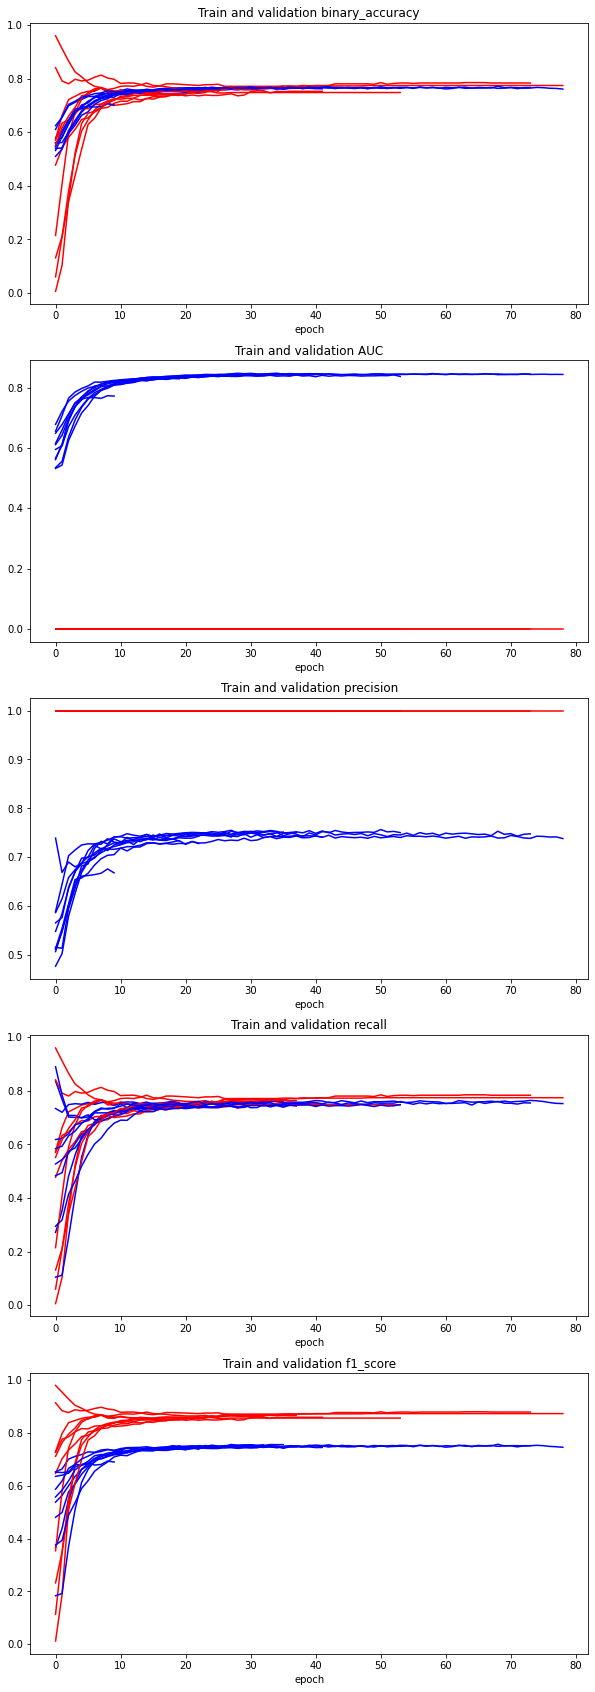

In [58]:
# compile model
learning_rate = 0.5e-3

# define training and validation parameters
batch_size = 256
epochs = 1000
validation_split = 0.1
n_splits = 10

# define callbacks
earlyStopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 9)
decayLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 1)
callbacks = [decayLR, earlyStopping]

results = kfold_train(
                    X, Y,
                    n_splits,
                    learning_rate,
                    batch_size,
                    epochs,
                    validation_split,
                    callbacks,
                    metrics)
            


## Training final model

In [82]:
# compile model
learning_rate = 0.5e-3

# define training and validation parameters
batch_size = 64
epochs = 1000
validation_split = 0.1

# define callbacks
earlyStopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 9)
decayLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 1)
callbacks = [decayLR, earlyStopping]

# ----- define model ----- 
model = ResNet2_ensemble5(2, (50,))
model.model().summary()

# ----- compile model -----
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
      loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
      metrics = metrics
     )

# ----- train and validate model -----
history = model.fit(X_train, Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_split = validation_split,
                    shuffle = True)

results = model.evaluate(X_test, Y_test)

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
res_net2_115 (ResNet2)          (None, 1)            145         input_22[0][0]                   
__________________________________________________________________________________________________
res_net2_116 (ResNet2)          (None, 1)            145         input_22[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_84 (TFOpLa (None, 1)            0           res_net2_115[0][0]               
                                                                 res_net2_116[0][0]        

86/86 [==============================] - 4s 44ms/step - loss: 0.4815 - binary_accuracy: 0.7668 - AUC: 0.8481 - precision: 0.7620 - recall: 0.8038 - f1_score: 0.7823 - val_loss: 0.5141 - val_binary_accuracy: 0.7594 - val_AUC: 0.8241 - val_precision: 0.7436 - val_recall: 0.8208 - val_f1_score: 0.7803
Epoch 18/1000
86/86 [==============================] - 4s 41ms/step - loss: 0.4793 - binary_accuracy: 0.7684 - AUC: 0.8494 - precision: 0.7629 - recall: 0.8066 - f1_score: 0.7841 - val_loss: 0.5145 - val_binary_accuracy: 0.7561 - val_AUC: 0.8247 - val_precision: 0.7380 - val_recall: 0.8239 - val_f1_score: 0.7786
Epoch 19/1000
86/86 [==============================] - 4s 41ms/step - loss: 0.4812 - binary_accuracy: 0.7695 - AUC: 0.8483 - precision: 0.7651 - recall: 0.8052 - f1_score: 0.7846 - val_loss: 0.5138 - val_binary_accuracy: 0.7545 - val_AUC: 0.8247 - val_precision: 0.7346 - val_recall: 0.8270 - val_f1_score: 0.7781
Epoch 20/1000
86/86 [==============================] - 3s 41ms/step - lo

Epoch 43/1000
86/86 [==============================] - 4s 41ms/step - loss: 0.4705 - binary_accuracy: 0.7717 - AUC: 0.8546 - precision: 0.7659 - recall: 0.8097 - f1_score: 0.7872 - val_loss: 0.5060 - val_binary_accuracy: 0.7594 - val_AUC: 0.8300 - val_precision: 0.7450 - val_recall: 0.8176 - val_f1_score: 0.7796

Epoch 00043: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
Epoch 00043: early stopping
34/34 [==============================] - 1s 17ms/step - loss: 0.4651 - binary_accuracy: 0.7799 - AUC: 0.8548 - precision: 0.7628 - recall: 0.8327 - f1_score: 0.7962


In [83]:
model.save_weights('resnet_weights_v1.tf')

# Feature tokenizer - transformer

## Defining model

In [88]:
class FeatureTokenizer(Layer):
    def __init__(self, numVar, d = 16):
        super(FeatureTokenizer, self).__init__()
        self.dense = layers.Dense(units = numVar * d)
        self.d = d
        self.reshape = layers.Reshape((numVar, d))
        
    def call(self, input_tensor):
        return self.reshape(self.dense(input_tensor))

class TransformerBlock(Layer):
    def __init__(self, num_heads = 10, keyValueDim = 16, mlpDropout = 0.1, atDropout = 0.2):
        super(TransformerBlock, self).__init__()
        
        # pre-norm and attention
        self.bn1 = layers.BatchNormalization()
        self.attention = layers.MultiHeadAttention(num_heads = num_heads,
                                                   key_dim = keyValueDim,
                                                   value_dim = keyValueDim,
                                                   dropout = atDropout)
        
        # pre-norm and MLP
        self.bn2 = layers.BatchNormalization()
        self.dense = layers.Dense(units = keyValueDim, activation = tf.nn.relu)
        self.drop = tf.keras.layers.Dropout(rate = mlpDropout)
        
        
    def call(self, input_tensor):  
        x = self.attention(self.bn1(input_tensor), self.bn1(input_tensor))
        x_inter = x + input_tensor
        x = self.drop(self.dense((self.bn2(x_inter))))
        return x + x_inter


In [89]:
class FT_Transformer3(Model):
    def __init__(self, numVar, d, num_heads, inp_shape):
        super(FT_Transformer3, self).__init__()
        self.ft = FeatureTokenizer(numVar = numVar, d = d)
        self.t1 = TransformerBlock(num_heads = num_heads, keyValueDim = d)
        self.t2 = TransformerBlock(num_heads = num_heads, keyValueDim = d)
        self.t3 = TransformerBlock(num_heads = num_heads, keyValueDim = d)
        self.max = layers.Maximum()
        self.final = BinaryClassifier()
        self.inp_shape = inp_shape
        
    def call(self, input_tensor):
        x = self.ft(input_tensor)
        x = self.t3(self.t2(self.t1(x)))
        x = tf.math.reduce_max(x, axis = 1)
        return self.final(x)
        
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))

In [90]:
class FT_Transformer3_ensemble5(Model):
    def __init__(self, numVar, d, num_heads, inp_shape):
        super(FT_Transformer3_ensemble5, self).__init__()
        self.model1 = FT_Transformer3(numVar = numVar, d = d, num_heads = num_heads, inp_shape = inp_shape)
        self.model2 = FT_Transformer3(numVar = numVar, d = d, num_heads = num_heads, inp_shape = inp_shape)
        self.model3 = FT_Transformer3(numVar = numVar, d = d, num_heads = num_heads, inp_shape = inp_shape)
        self.model4 = FT_Transformer3(numVar = numVar, d = d, num_heads = num_heads, inp_shape = inp_shape)
        self.model5 = FT_Transformer3(numVar = numVar, d = d, num_heads = num_heads, inp_shape = inp_shape)
        self.inp_shape = inp_shape
        
    def call(self, input_tensor):
        x1 = self.model1(input_tensor)
        x2 = self.model2(input_tensor)
        x3 = self.model3(input_tensor)
        x4 = self.model4(input_tensor)
        x5 = self.model5(input_tensor)
        return (x1 + x2 + x3 + x4 + x5)/5
    
    def model(self):
        x = keras.Input(shape = self.inp_shape)
        return Model(inputs = x, outputs = self.call(x))
    

## Testing model

In [91]:
def kfold_train(model, X, Y, n_splits, learning_rate, batch_size, epochs, validation_split, callbacks, metrics):
    import matplotlib.pyplot as plt
    # initializing plots and results
    fig, ax = plt.subplots(nrows = len(metrics), figsize = (10, 30))
    results = np.empty((n_splits,len(metrics) + 1), dtype = 'float64')
    count = 0

    # train test kfold
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = n_splits, shuffle = True).split(X)
    for train_index, test_index in kf:
        print(f"\n##### NEW RUN {count + 1} ##### \n")
        
        # set train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ----- define model ----- 
        ##### CHANGE HERE #####
        model = FT_Transformer3_ensemble5(numVar = 21, d = 2, num_heads = 2, inp_shape = (50,))
        model.model().summary()
        
        # ----- compile model -----
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics = metrics
             )

        # ----- train and validate model -----
        history = model.fit(X_train, y_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            callbacks = callbacks,
                            validation_split = validation_split,
                            shuffle = True)


        for m in range(len(metrics)):
            ax[m].set_xlabel("epoch")
            ax[m].set_title(f"Train and validation {metrics[m].name}")
            ax[m].plot(history.history[f'val_{metrics[m].name}'], label = f"validation{count}", color = 'r')
            ax[m].plot(history.history[f'{metrics[m].name}'], label = f"train{count}", color = 'b')
        
        # evaluation
        results[count] = model.evaluate(X_test, y_test)
        count += 1

    mean = np.mean(results, axis = 0)
    std = np.std(results, axis = 0)
    print("##### Results #####")
    for m in range(0,len(metrics)):
        print(f'{metrics[m].name} mean is: {mean[m+1]}, std. deviation is: {std[m+1]}')

    return results


##### NEW RUN 1 ##### 

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
ft__transformer3_25 (FT_Transfo (None, 1)            2349        input_28[0][0]                   
__________________________________________________________________________________________________
ft__transformer3_26 (FT_Transfo (None, 1)            2349        input_28[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_108 (TFOpL (None, 1)            0           ft__transformer3_25[0][0]        
                                                                 f


Epoch 00016: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 17/1000
22/22 [==============================] - 2s 98ms/step - loss: 0.4631 - binary_accuracy: 0.7742 - AUC: 0.8585 - precision: 0.7484 - recall: 0.7272 - f1_score: 0.7376 - val_loss: 0.6133 - val_binary_accuracy: 0.6866 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6866 - val_f1_score: 0.8142
Epoch 18/1000
22/22 [==============================] - 2s 105ms/step - loss: 0.4631 - binary_accuracy: 0.7724 - AUC: 0.8585 - precision: 0.7444 - recall: 0.7288 - f1_score: 0.7365 - val_loss: 0.6131 - val_binary_accuracy: 0.6835 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6835 - val_f1_score: 0.8120
Epoch 19/1000
22/22 [==============================] - 2s 100ms/step - loss: 0.4626 - binary_accuracy: 0.7733 - AUC: 0.8592 - precision: 0.7447 - recall: 0.7313 - f1_score: 0.7379 - val_loss: 0.6093 - val_binary_accuracy: 0.6856 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_

Epoch 13/1000
22/22 [==============================] - 2s 97ms/step - loss: 0.4598 - binary_accuracy: 0.7777 - AUC: 0.8606 - precision: 0.7557 - recall: 0.7231 - f1_score: 0.7390 - val_loss: 0.5130 - val_binary_accuracy: 0.7546 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7546 - val_f1_score: 0.8602
Epoch 14/1000
22/22 [==============================] - 2s 105ms/step - loss: 0.4564 - binary_accuracy: 0.7780 - AUC: 0.8624 - precision: 0.7550 - recall: 0.7256 - f1_score: 0.7400 - val_loss: 0.5195 - val_binary_accuracy: 0.7464 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7464 - val_f1_score: 0.8548
Epoch 15/1000
22/22 [==============================] - 3s 117ms/step - loss: 0.4525 - binary_accuracy: 0.7786 - AUC: 0.8647 - precision: 0.7555 - recall: 0.7265 - f1_score: 0.7407 - val_loss: 0.4936 - val_binary_accuracy: 0.7546 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7546 - val_f1_score: 0.8602
Epoch 16/1000
22/22 [=======================

22/22 [==============================] - 18s 277ms/step - loss: 0.9522 - binary_accuracy: 0.5844 - AUC: 0.6282 - precision: 0.7720 - recall: 0.1011 - f1_score: 0.1788 - val_loss: 1.7390 - val_binary_accuracy: 0.0000e+00 - val_AUC: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/1000
22/22 [==============================] - 3s 144ms/step - loss: 0.7988 - binary_accuracy: 0.5626 - AUC: 0.6504 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.4253 - val_binary_accuracy: 0.0000e+00 - val_AUC: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/1000
22/22 [==============================] - 3s 124ms/step - loss: 0.6972 - binary_accuracy: 0.5626 - AUC: 0.7227 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.1841 - val_binary_accuracy: 0.0000e+00 - val_AUC: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_scor

22/22 [==============================] - 3s 116ms/step - loss: 0.4565 - binary_accuracy: 0.7833 - AUC: 0.8653 - precision: 0.7531 - recall: 0.7506 - f1_score: 0.7519 - val_loss: 0.5080 - val_binary_accuracy: 0.7649 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7649 - val_f1_score: 0.8668
Epoch 27/1000
22/22 [==============================] - 3s 125ms/step - loss: 0.4557 - binary_accuracy: 0.7868 - AUC: 0.8656 - precision: 0.7596 - recall: 0.7498 - f1_score: 0.7547 - val_loss: 0.5165 - val_binary_accuracy: 0.7557 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7557 - val_f1_score: 0.8608
Epoch 28/1000
22/22 [==============================] - 3s 117ms/step - loss: 0.4503 - binary_accuracy: 0.7871 - AUC: 0.8697 - precision: 0.7658 - recall: 0.7394 - f1_score: 0.7524 - val_loss: 0.5127 - val_binary_accuracy: 0.7577 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7577 - val_f1_score: 0.8622
Epoch 29/1000
22/22 [==============================] - 3s

Epoch 2/1000
22/22 [==============================] - 3s 130ms/step - loss: 0.6465 - binary_accuracy: 0.6553 - AUC: 0.7119 - precision: 0.6173 - recall: 0.5436 - f1_score: 0.5781 - val_loss: 0.6969 - val_binary_accuracy: 0.4546 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.4546 - val_f1_score: 0.6251
Epoch 3/1000
22/22 [==============================] - 3s 128ms/step - loss: 0.6094 - binary_accuracy: 0.7092 - AUC: 0.7785 - precision: 0.6675 - recall: 0.6588 - f1_score: 0.6632 - val_loss: 0.6188 - val_binary_accuracy: 0.6082 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6082 - val_f1_score: 0.7564
Epoch 4/1000
22/22 [==============================] - 3s 130ms/step - loss: 0.5692 - binary_accuracy: 0.7347 - AUC: 0.8060 - precision: 0.6917 - recall: 0.7024 - f1_score: 0.6970 - val_loss: 0.5873 - val_binary_accuracy: 0.6567 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6567 - val_f1_score: 0.7928
Epoch 5/1000
22/22 [==========================

22/22 [==============================] - 2s 108ms/step - loss: 0.5434 - binary_accuracy: 0.7420 - AUC: 0.8131 - precision: 0.7083 - recall: 0.6985 - f1_score: 0.7034 - val_loss: 0.5782 - val_binary_accuracy: 0.7680 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7680 - val_f1_score: 0.8688ary_accuracy: 0.7387 - AUC: 0.8120 - precision: 0.7037 - recall: 0.6811 - f1_s - ETA: 0s - loss: 0.5434 - binary_accuracy: 0.7420 - AUC: 0.8131 - precision: 0.7083 - recall: 0.6985 - f1_score: 0.703
Epoch 4/1000
22/22 [==============================] - 2s 111ms/step - loss: 0.5249 - binary_accuracy: 0.7458 - AUC: 0.8210 - precision: 0.7070 - recall: 0.7164 - f1_score: 0.7117 - val_loss: 0.5875 - val_binary_accuracy: 0.7536 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7536 - val_f1_score: 0.8595
Epoch 5/1000
22/22 [==============================] - 2s 107ms/step - loss: 0.5110 - binary_accuracy: 0.7542 - AUC: 0.8291 - precision: 0.7159 - recall: 0.7272 - f1_score: 0.7215 

22/22 [==============================] - 20s 281ms/step - loss: 0.6586 - binary_accuracy: 0.6300 - AUC: 0.7090 - precision: 0.5636 - recall: 0.7381 - f1_score: 0.6391 - val_loss: 0.7868 - val_binary_accuracy: 0.3495 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.3495 - val_f1_score: 0.5180
Epoch 2/1000
22/22 [==============================] - 3s 120ms/step - loss: 0.5824 - binary_accuracy: 0.7425 - AUC: 0.7973 - precision: 0.7166 - recall: 0.6771 - f1_score: 0.6963 - val_loss: 0.7279 - val_binary_accuracy: 0.5278 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5278 - val_f1_score: 0.6910
Epoch 3/1000
22/22 [==============================] - 3s 117ms/step - loss: 0.5439 - binary_accuracy: 0.7582 - AUC: 0.8253 - precision: 0.7280 - recall: 0.7109 - f1_score: 0.7194 - val_loss: 0.6837 - val_binary_accuracy: 0.6021 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6021 - val_f1_score: 0.7516
Epoch 4/1000
22/22 [==============================] - 3s 1

22/22 [==============================] - 3s 117ms/step - loss: 0.4461 - binary_accuracy: 0.7808 - AUC: 0.8693 - precision: 0.7463 - recall: 0.7531 - f1_score: 0.7497 - val_loss: 0.5391 - val_binary_accuracy: 0.7330 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7330 - val_f1_score: 0.8459
Epoch 27/1000
22/22 [==============================] - 2s 113ms/step - loss: 0.4446 - binary_accuracy: 0.7879 - AUC: 0.8706 - precision: 0.7538 - recall: 0.7623 - f1_score: 0.7580 - val_loss: 0.5373 - val_binary_accuracy: 0.7381 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7381 - val_f1_score: 0.8493
Epoch 28/1000
22/22 [==============================] - 3s 116ms/step - loss: 0.4439 - binary_accuracy: 0.7861 - AUC: 0.8710 - precision: 0.7553 - recall: 0.7531 - f1_score: 0.7542 - val_loss: 0.5356 - val_binary_accuracy: 0.7402 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7402 - val_f1_score: 0.8507
Epoch 29/1000
22/22 [==============================] - 2s

22/22 [==============================] - 20s 222ms/step - loss: 0.6708 - binary_accuracy: 0.6021 - AUC: 0.6771 - precision: 0.7992 - recall: 0.1386 - f1_score: 0.2362 - val_loss: 0.8825 - val_binary_accuracy: 0.0412 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.0412 - val_f1_score: 0.0792
Epoch 2/1000
22/22 [==============================] - 3s 127ms/step - loss: 0.5945 - binary_accuracy: 0.6772 - AUC: 0.7940 - precision: 0.7798 - recall: 0.3567 - f1_score: 0.4895 - val_loss: 0.7420 - val_binary_accuracy: 0.4515 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.4515 - val_f1_score: 0.6222
Epoch 3/1000
22/22 [==============================] - 3s 138ms/step - loss: 0.5407 - binary_accuracy: 0.7513 - AUC: 0.8284 - precision: 0.7557 - recall: 0.6307 - f1_score: 0.6876 - val_loss: 0.6519 - val_binary_accuracy: 0.6505 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6505 - val_f1_score: 0.7883
Epoch 4/1000
22/22 [==============================] - 3s 1

22/22 [==============================] - 15s 201ms/step - loss: 0.6798 - binary_accuracy: 0.5800 - AUC: 0.6319 - precision: 0.5257 - recall: 0.6148 - f1_score: 0.5668 - val_loss: 0.5792 - val_binary_accuracy: 0.9526 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.9526 - val_f1_score: 0.9757
Epoch 2/1000
22/22 [==============================] - 3s 114ms/step - loss: 0.5987 - binary_accuracy: 0.7154 - AUC: 0.7793 - precision: 0.7177 - recall: 0.5703 - f1_score: 0.6356 - val_loss: 0.5788 - val_binary_accuracy: 0.7856 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7856 - val_f1_score: 0.8799
Epoch 3/1000
22/22 [==============================] - 3s 116ms/step - loss: 0.5322 - binary_accuracy: 0.7527 - AUC: 0.8217 - precision: 0.7322 - recall: 0.6808 - f1_score: 0.7056 - val_loss: 0.5589 - val_binary_accuracy: 0.7381 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7381 - val_f1_score: 0.8493
Epoch 4/1000
22/22 [==============================] - 2s 1

22/22 [==============================] - 2s 113ms/step - loss: 0.4961 - binary_accuracy: 0.7566 - AUC: 0.8365 - precision: 0.7239 - recall: 0.7145 - f1_score: 0.7192 - val_loss: 0.6339 - val_binary_accuracy: 0.7402 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7402 - val_f1_score: 0.8507ary_accuracy: 0.7561 - AUC: 0.8367 - precision: 0.7242 - recall: 0.7134 - f1_score: 0.71
Epoch 7/1000
22/22 [==============================] - 2s 111ms/step - loss: 0.4867 - binary_accuracy: 0.7626 - AUC: 0.8420 - precision: 0.7281 - recall: 0.7275 - f1_score: 0.7278 - val_loss: 0.5988 - val_binary_accuracy: 0.7485 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7485 - val_f1_score: 0.8561
Epoch 8/1000
22/22 [==============================] - 2s 111ms/step - loss: 0.4817 - binary_accuracy: 0.7646 - AUC: 0.8453 - precision: 0.7287 - recall: 0.7333 - f1_score: 0.7310 - val_loss: 0.5687 - val_binary_accuracy: 0.7619 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0

22/22 [==============================] - 3s 118ms/step - loss: 0.4533 - binary_accuracy: 0.7766 - AUC: 0.8633 - precision: 0.7381 - recall: 0.7563 - f1_score: 0.7471 - val_loss: 0.4772 - val_binary_accuracy: 0.8000 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.8000 - val_f1_score: 0.8889
Epoch 31/1000
22/22 [==============================] - 2s 111ms/step - loss: 0.4575 - binary_accuracy: 0.7742 - AUC: 0.8604 - precision: 0.7381 - recall: 0.7479 - f1_score: 0.7430 - val_loss: 0.4769 - val_binary_accuracy: 0.8000 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.8000 - val_f1_score: 0.8889
Epoch 32/1000
22/22 [==============================] - 2s 112ms/step - loss: 0.4555 - binary_accuracy: 0.7784 - AUC: 0.8622 - precision: 0.7427 - recall: 0.7529 - f1_score: 0.7478 - val_loss: 0.4775 - val_binary_accuracy: 0.8000 - val_AUC: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.8000 - val_f1_score: 0.8889

Epoch 00032: ReduceLROnPlateau reducing learning rate to

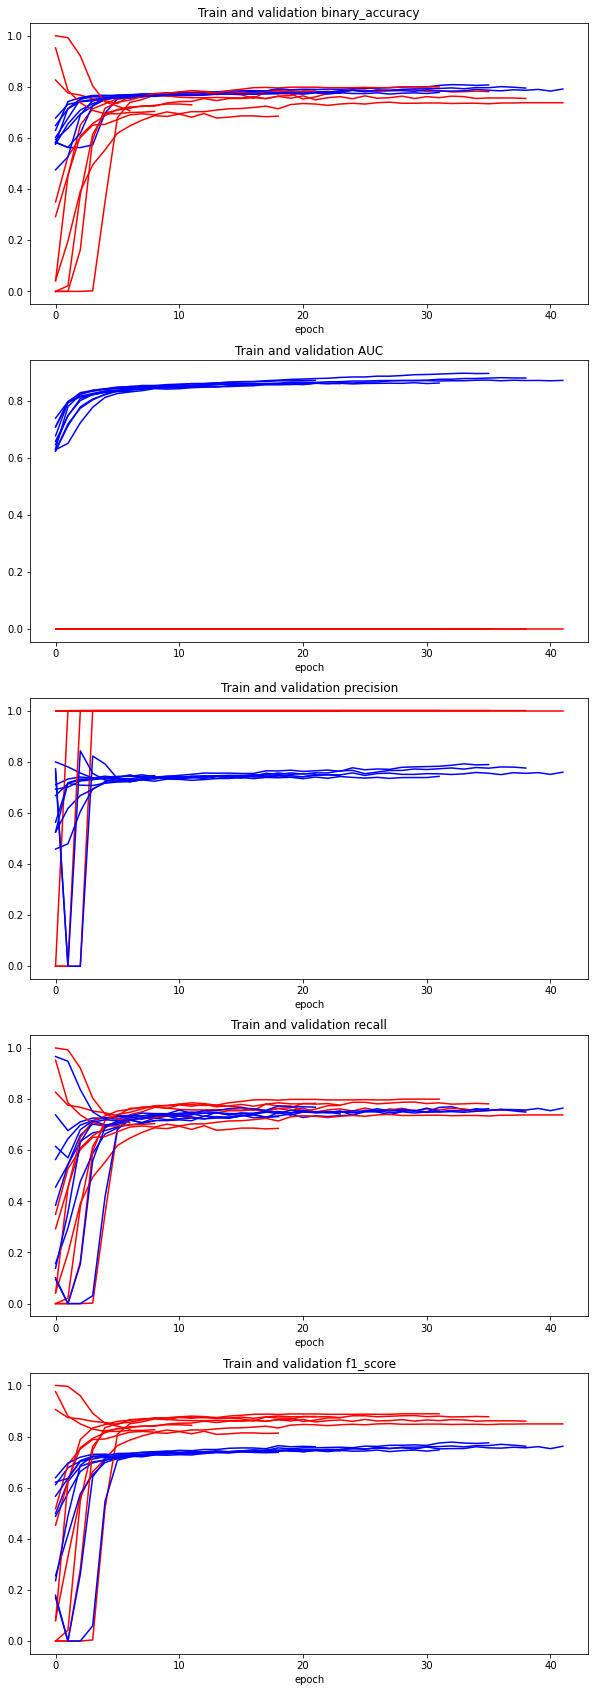

In [93]:
# compile model
learning_rate = 0.5e-3

# define training and validation parameters
batch_size = 256
epochs = 1000
validation_split = 0.15
n_splits = 10

# define callbacks
earlyStopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 6)
decayLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 1)
callbacks = [decayLR, earlyStopping]

results = kfold_train(model,
                    X, Y,
                    n_splits,
                    learning_rate,
                    batch_size,
                    epochs,
                    validation_split,
                    callbacks,
                    metrics)
            


## Training final model

In [94]:
# compile model
learning_rate = 0.5e-3

# define training and validation parameters
batch_size = 64
epochs = 1000
validation_split = 0.1

# define callbacks
earlyStopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 9)
decayLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 1)
callbacks = [decayLR, earlyStopping]

# ----- define model ----- 
model = model = FT_Transformer3_ensemble5(numVar = 21, d = 2, num_heads = 2, inp_shape = (50,))
model.model().summary()

# ----- compile model -----
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
      loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
      metrics = metrics
     )

# ----- train and validate model -----
history = model.fit(X_train, Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_split = validation_split,
                    shuffle = True)

results = model.evaluate(X_test, Y_test)

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
ft__transformer3_75 (FT_Transfo (None, 1)            2349        input_38[0][0]                   
__________________________________________________________________________________________________
ft__transformer3_76 (FT_Transfo (None, 1)            2349        input_38[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_148 (TFOpL (None, 1)            0           ft__transformer3_75[0][0]        
                                                                 ft__transformer3_76[0][0] 

86/86 [==============================] - 9s 110ms/step - loss: 0.4456 - binary_accuracy: 0.7879 - AUC: 0.8702 - precision: 0.7803 - recall: 0.8258 - f1_score: 0.8024 - val_loss: 0.4948 - val_binary_accuracy: 0.7660 - val_AUC: 0.8386 - val_precision: 0.7566 - val_recall: 0.8113 - val_f1_score: 0.7830
Epoch 13/1000
86/86 [==============================] - 9s 109ms/step - loss: 0.4429 - binary_accuracy: 0.7904 - AUC: 0.8716 - precision: 0.7873 - recall: 0.8195 - f1_score: 0.8031 - val_loss: 0.4947 - val_binary_accuracy: 0.7643 - val_AUC: 0.8390 - val_precision: 0.7544 - val_recall: 0.8113 - val_f1_score: 0.7818
Epoch 14/1000
86/86 [==============================] - 9s 105ms/step - loss: 0.4393 - binary_accuracy: 0.7899 - AUC: 0.8738 - precision: 0.7852 - recall: 0.8219 - f1_score: 0.8031 - val_loss: 0.4955 - val_binary_accuracy: 0.7594 - val_AUC: 0.8388 - val_precision: 0.7507 - val_recall: 0.8050 - val_f1_score: 0.7769ccuracy: 0.7961 - AUC: 0.8768 - precision: 0.8091 - recall - ETA: 3s -

86/86 [==============================] - 9s 104ms/step - loss: 0.4054 - binary_accuracy: 0.8119 - AUC: 0.8928 - precision: 0.8016 - recall: 0.8495 - f1_score: 0.8249 - val_loss: 0.4888 - val_binary_accuracy: 0.7627 - val_AUC: 0.8435 - val_precision: 0.7493 - val_recall: 0.8176 - val_f1_score: 0.7820C: 0.8936 - precision: 0.8078 - recall: 0.8378 - f1_score: 0.8 - ETA: 3s - loss: 0.4036 - binary_accuracy: 0.8115 - AUC: 0.8942 - precision: 0.805

Epoch 00030: ReduceLROnPlateau reducing learning rate to 5.000000328436726e-07.
Epoch 31/1000
86/86 [==============================] - 9s 105ms/step - loss: 0.4092 - binary_accuracy: 0.8094 - AUC: 0.8901 - precision: 0.7999 - recall: 0.8460 - f1_score: 0.8223 - val_loss: 0.4888 - val_binary_accuracy: 0.7643 - val_AUC: 0.8434 - val_precision: 0.7514 - val_recall: 0.8176 - val_f1_score: 0.783178 - AUC: 0.8880 - precision: 0.7952 - recall: 0.8478 - f1_score:  - ETA: 0s - loss: 0.4112 - binary_accuracy: 0.8081 - AUC: 0.8888 - precision: 0.7984 - reca

In [96]:
model.save_weights('FTT_weights_v1.tf')